In [ ]:
import ffn
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import pickle
import talib
from talib import MA_Type
import requests

In [2]:
# 讀出預先下載好的股價資料
with open('stockdata', 'rb') as f:
    data = pickle.load(file=f)

# Q1. 畫出 Diamond Shape

# Q2. 刪除重複性資料

從 symbols01.txt 跟 symbols02.txt 讀入兩組股票代號，合併兩組代號，輸出一份無重複的股票代號到 symbols03.txt。

# Q3. 下載台灣上市公司基本資料

寫一個程式從 [http://dts.twse.com.tw/opendata/t187ap03_L.csv](http://dts.twse.com.tw/opendata/t187ap03_L.csv) 下載台灣上市公司基本資料，並輸出成 pandas dataframe。

# Q4. 畫出技術曲線

請畫出除了上課提過的線型之外的任何技術曲線，並寫註解說明。

In [3]:
df = data['GOOG']

In [4]:
# 計算均線
df['20d'] = pd.Series.rolling(df['Close'], window=20).mean()
df['60d'] = pd.Series.rolling(df['Close'], window=60).mean()

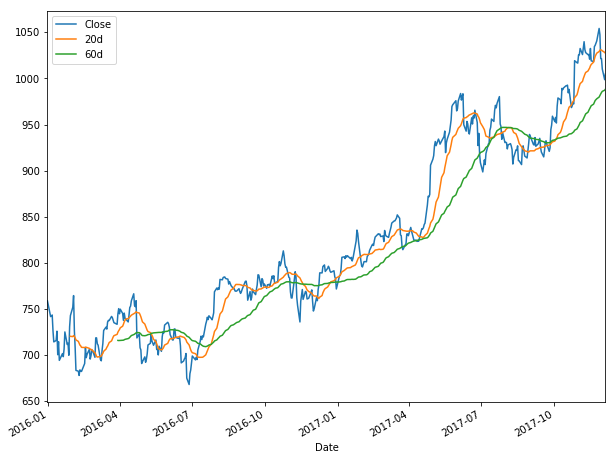

In [5]:
df[['Close', '20d', '60d']].plot(legend='best', figsize=(10,8))

# Q5. 策略回測

In [6]:
# 計算 MaxDD
def DrawDownAnalysis(cumRet):
    dd_series = ffn.core.to_drawdown_series(cumRet)
    dd_details = ffn.core.drawdown_details(dd_series)
    return dd_details['drawdown'].min(), dd_details['days'].max()

In [7]:
# 利用策略產生的持有部位資訊，計算底下四個指標來判斷投資績效
# sharpe ratio: 判斷報酬的好壞跟穩定度，數值越大越好
# maxdd: maximum drawdown, 最糟糕的狀況會賠幾 %
# maxddd: maximum drawdown duration, 低於上一次最高報酬的天數
# cumRet[-1]: 最後賺的 % 數

def indicators(df):
    dailyRet = df['Close'].pct_change()
    excessRet = (dailyRet - 0.04/252)[df['positions'] == 1]
    SharpeRatio = np.sqrt(252.0)*np.mean(excessRet)/np.std(excessRet)
    
    cumRet = np.cumprod(1+excessRet)
    
    maxdd, maxddd = DrawDownAnalysis(cumRet)
    
    return SharpeRatio, maxdd, maxddd, cumRet[-1]

In [8]:
# 這是我們的策略的部分
# 主要只是要算出進出的訊號 signals 跟何時持有部位 positions
# 底下是一個突破系統的範例

def Breakout_strategy(df):
    # Donchian Channel
    df['20d_high'] = np.round(pd.Series.rolling(df['Close'], window=20).max(), 2)
    df['10d_low'] = np.round(pd.Series.rolling(df['Close'], window=10).min(), 2)

    has_position = False
    df['signals'] = 0
    for t in range(2, df['signals'].size):
        if df['Close'][t] > df['20d_high'][t-1]:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        elif df['Close'][t] < df['10d_low'][t-1]:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()
    return df

In [9]:
def RSI_7030_strategy(df):
    df['RSI'] = talib.RSI(df['Close'].values)
    
    has_position = False
    df['signals'] = 0
    for t in range(2, df['signals'].size):
        if df['RSI'][t-1] < 30:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        elif df['RSI'][t-1] > 70:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()
    return df

In [10]:
def BBands_strategy(df):
    df['UBB'], df['MBB'], df['LBB'] = talib.BBANDS(df['Close'].values, matype=MA_Type.T3)

    has_position = False
    df['signals'] = 0
    for t in range(2, df['signals'].size):
        if df['Close'][t] < df['LBB'][t-1]:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        elif df['Close'][t] > df['UBB'][t-1]:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()
    return df

In [11]:
# 定義你的策略

def 學號_strategy(df):
    has_position = False
    df['signals'] = 0
    
    # TODO
    # 填入你們的策略

    df['positions'] = df['signals'].cumsum().shift()
    return df

In [12]:
def apply_strategy(strategy, df):
    return strategy(df)

In [13]:
# 計算各支股票的回測結果
results = []

#strategies = [Breakout_strategy, RSI_7030_strategy, BBands_strategy, 學號_strategy]
strategies = [Breakout_strategy, RSI_7030_strategy, BBands_strategy]

for symbol in data:
    for strategy in strategies:
        try:
            apply_strategy(strategy, data[symbol])
            if np.all(data[symbol]['signals']==0):
                print("Symbol:", symbol, "使用", strategy.__name__, "策略沒有出現買賣訊號。")
                continue
            SharpeRatio, maxdd, maxddd, finalRet = indicators(data[symbol])
            days = (data[symbol].index[-1] - data[symbol].index[0]).days
            results.append((SharpeRatio, maxdd, maxddd, finalRet, days,
                            data[symbol][data[symbol]['signals'] > 0]['signals'].sum(), symbol, strategy.__name__))
        except Exception as e:
            print("Error occurs at symbol:", symbol, "Strategy:", strategy.__name__, "==>", e.args)

In [14]:
results_df = pd.DataFrame(results, columns=['sharpe','MaxDrawDown','MaxDrawDownDuration','returns', 
                                            'days', 'entries','symbol','strategy'])

In [15]:
results_df.head()

,sharpe,MaxDrawDown,MaxDrawDownDuration,returns,days,entries,symbol,strategy
0,0.131503,-0.208296,281,0.995734,705,11,TICC,Breakout_strategy
1,0.395515,-0.244817,482,1.077756,705,2,TICC,RSI_7030_strategy
2,0.102787,-0.231763,426,0.984521,705,20,TICC,BBands_strategy
3,1.365570,-0.361485,299,1.631388,705,12,TWIN,Breakout_strategy
4,2.424484,-0.169115,115,2.151881,705,3,TWIN,RSI_7030_strategy


In [16]:
results_df.sort_values('MaxDrawDown',ascending=False).head()

,sharpe,MaxDrawDown,MaxDrawDownDuration,returns,days,entries,symbol,strategy
55,6.306176,-0.003654,122,1.028222,473,3,LCA,RSI_7030_strategy
13,10.243474,-0.006251,3,1.132402,705,1,GOOG,RSI_7030_strategy
56,2.038551,-0.013673,119,1.060527,473,16,LCA,BBands_strategy
50,1.085572,-0.023454,135,1.049505,384,12,SCAC,BBands_strategy
27,3.040178,-0.023844,58,1.073352,203,3,CSML,Breakout_strategy


In [17]:
results_df.sort_values('returns',ascending=False).head()

,sharpe,MaxDrawDown,MaxDrawDownDuration,returns,days,entries,symbol,strategy
7,2.013777,-0.219296,167,2.477803,705,4,AMOT,RSI_7030_strategy
11,2.062962,-0.286661,113,2.422460,705,22,CDZI,BBands_strategy
59,2.136744,-0.454342,191,2.400221,705,21,BBGI,BBands_strategy
4,2.424484,-0.169115,115,2.151881,705,3,TWIN,RSI_7030_strategy
68,1.724711,-0.231083,481,1.717758,704,20,ISRL,BBands_strategy
